In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import patsy
from xgboost import XGBRegressor


In [24]:
classes = ['age', 'sex', 'weight', 'height']
path = '~/Desktop/ptb-xl/'
dataset = pd.read_json(path+'updated_ptbxl_database.json')
dataset = dataset[classes + ['ABNORM']]

print(len(dataset.dropna()))

5906


In [25]:
def load_data(classes=['age', 'sex', 'weight', 'height']):
    path = '~/Desktop/ptb-xl/'
    dataset = pd.read_json(path+'updated_ptbxl_database.json')
    dataset = dataset[classes + ['ABNORM']].dropna()

    test_split = int(0.8 * len(dataset))
    X = dataset[classes]
    y = dataset[['ABNORM']]

    train_df = pd.concat([X.iloc[:test_split], y.iloc[:test_split]], axis=1).dropna()
    test_df = pd.concat([X.iloc[test_split:], y.iloc[test_split:]], axis=1).dropna()

    train_data, train_labels = train_df[classes], train_df['ABNORM'].to_numpy()
    test_data, test_labels = test_df[classes], test_df['ABNORM'].to_numpy()

    return train_data, train_labels, test_data, test_labels

In [26]:
def logistic_regression(train_data, train_labels, test_data, test_labels, type='l1', data_string=""):
    coefs = []
    accuracies = []

    lambda_values = np.logspace(-1, 1, num=10)  # Generates 10 values logarithmically spaced between 10^-1 and 10^8

    for C in lambda_values:
        fit = LogisticRegression(penalty=type, solver='saga', warm_start=True, C=C, max_iter=10000).fit(train_data, train_labels)

        prediction_labels = fit.predict(test_data)
        accuracy = accuracy_score(test_labels, prediction_labels)

        coefs.append(C)
        accuracies.append(accuracy)
        
    plt.figure(figsize=(4, 4))
    plt.plot(coefs, accuracies)
    plt.title(f'{type} Logistic Regression Classifier: {data_string}')
    plt.xlabel('C')
    plt.ylabel('Classification Accuracy')
    plt.show()

In [27]:
def random_forests(train_data, train_labels, test_data, test_labels, data_string=""): 
    depths = []
    accuracies = []

    for depth in range(2, 15):

        fit = RandomForestClassifier(n_estimators=500, max_depth=depth).fit(train_data, train_labels)

        prediction_labels = fit.predict(test_data)
        accuracy = accuracy_score(test_labels, prediction_labels)

        depths.append(depth)
        accuracies.append(round(accuracy, 2))

    plt.figure(figsize=(4, 4))
    plt.plot(depths, accuracies)
    plt.title(f'Random Forests Classifier: {data_string}')
    plt.xlabel('Depth')
    plt.ylabel('Classification Accuracy')
    plt.show()

In [28]:
def xg_boost(train_data, train_labels, test_data, test_labels, data_string=''):
    depths = []
    accuracies = []

    for depth in range(2, 15):

        model = XGBRegressor(n_estimators=500, max_depth=depth, learning_rate=0.01, objective='reg:squarederror')
        model.fit(train_data.to_numpy().astype(np.float32), train_labels)

        prediction_labels = model.predict(test_data.to_numpy().astype(np.float32))
        threshold = 0.5
        prediction_labels = np.where(prediction_labels - np.floor(prediction_labels) >= threshold, np.ceil(prediction_labels), np.floor(prediction_labels)).astype(int)
        accuracy = accuracy_score(test_labels, prediction_labels)

        depths.append(depth)
        accuracies.append(accuracy)

    plt.figure(figsize=(4, 4))
    plt.plot(depths, accuracies)
    plt.title(f'XGBoost Classifier: {data_string}')
    plt.xlabel('Depth')
    plt.ylabel('Classification Accuracy')
    plt.show()

## Strategy - Try all combinations of each category
Types of data:
- weight, height
- age, weight, height
- sex, age, weight
- height, sex, age, weight

Models:
- l1 logistic regression
- l2 logistic regression
- Random Forests
- XGBoost

Representations:
- Basic
- Interaction

# Weight, Height

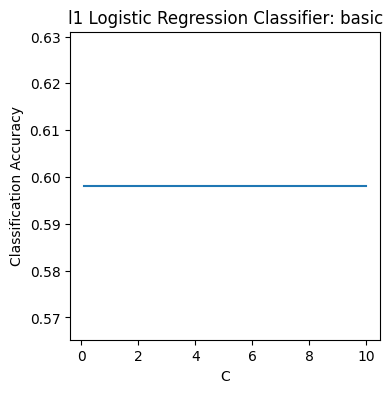

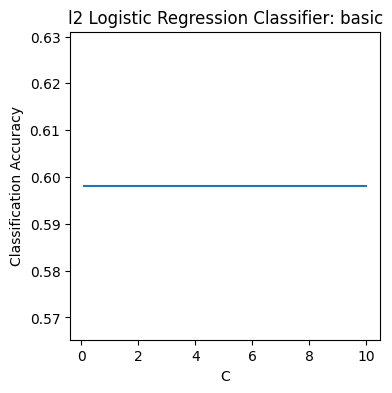

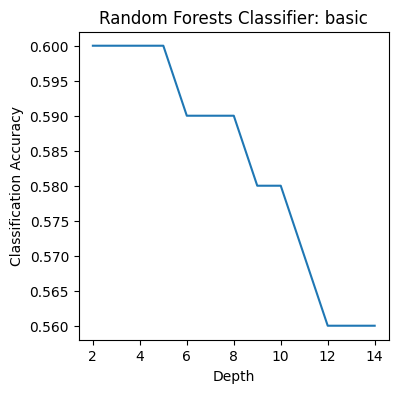

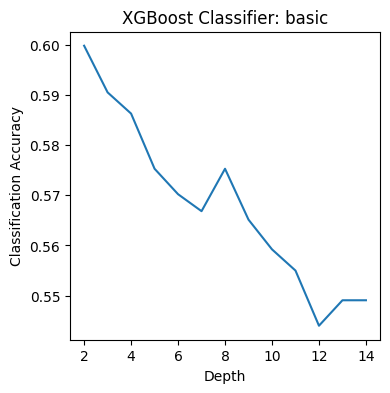

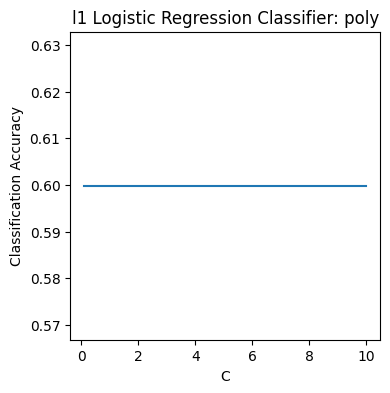

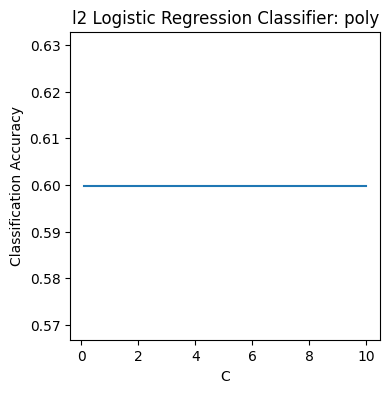

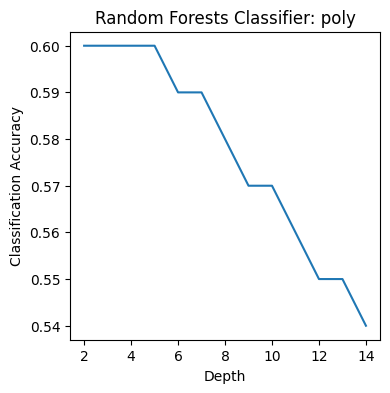

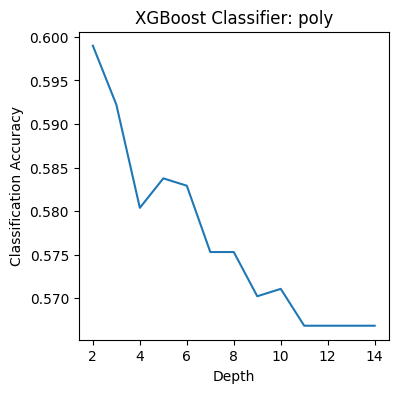

In [33]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['weight', 'height'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'height:weight'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Age, Weight, Height

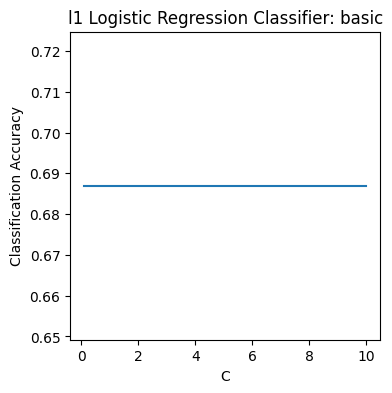

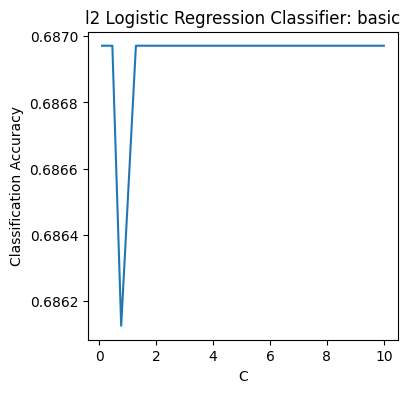

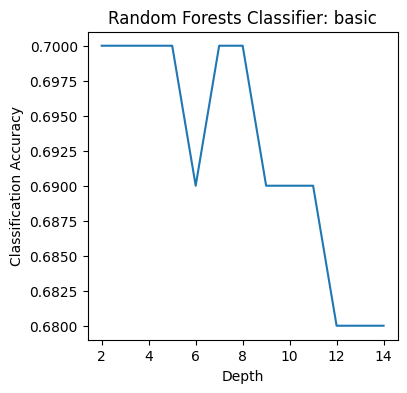

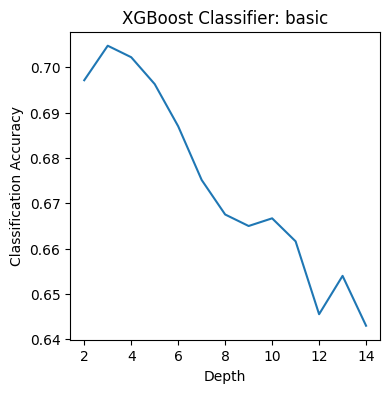

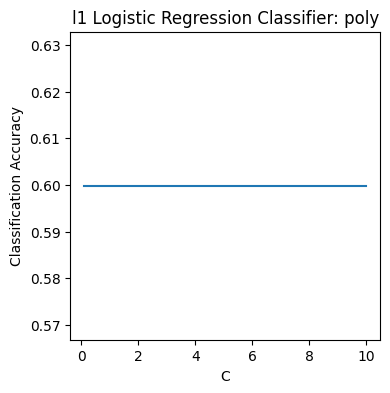

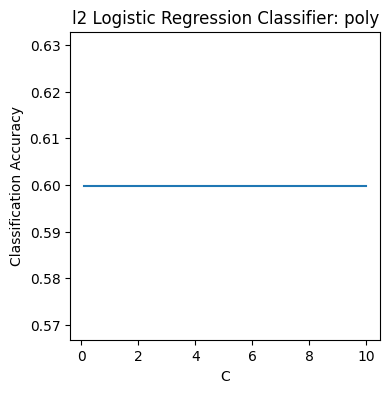

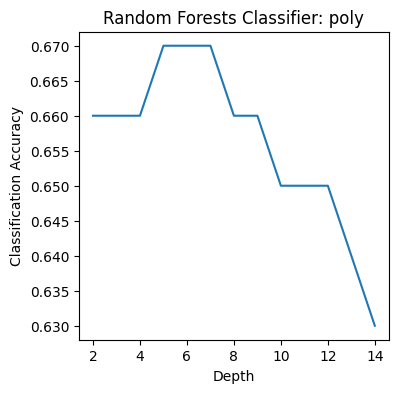

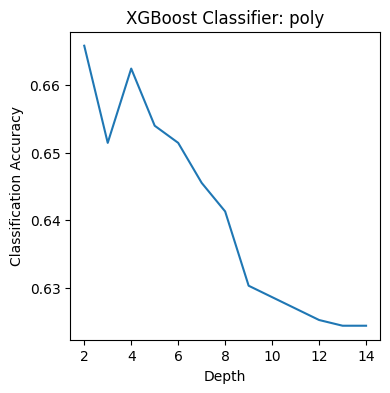

In [32]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['age', 'weight', 'height'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'height:weight:age'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Weight, Age, Sex

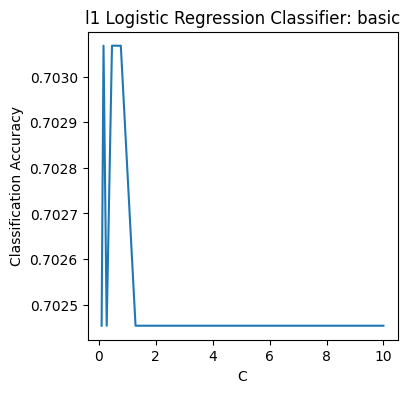

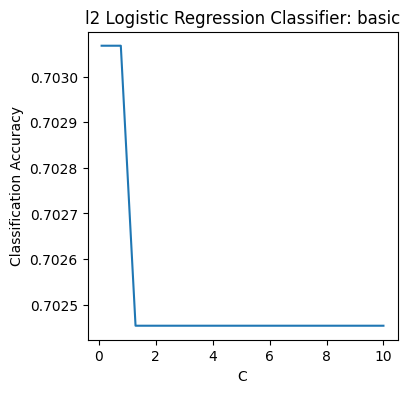

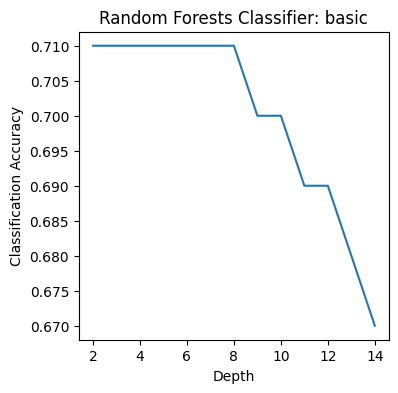

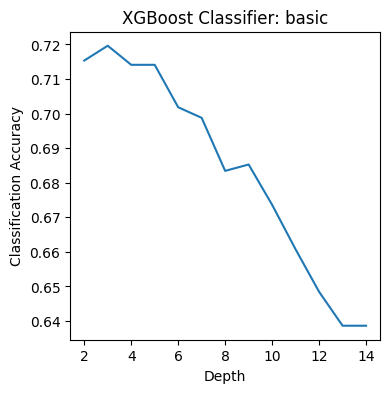

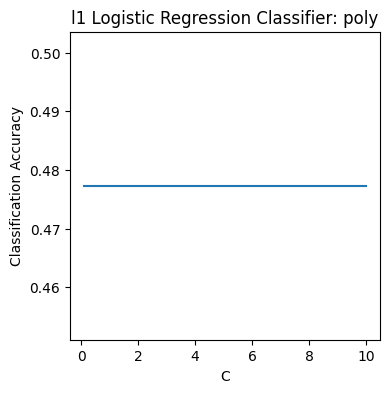

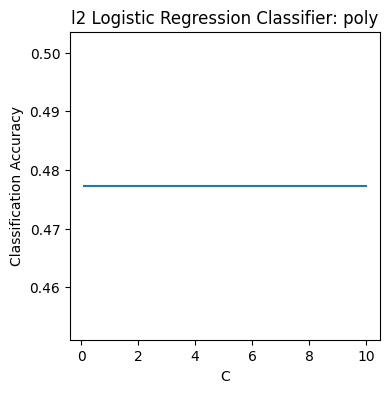

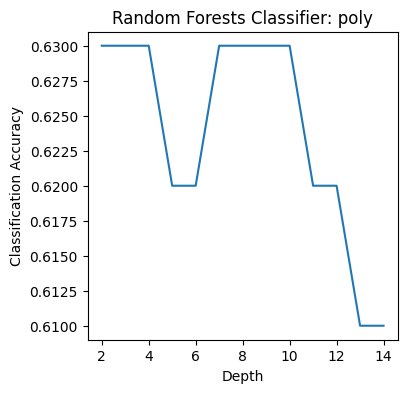

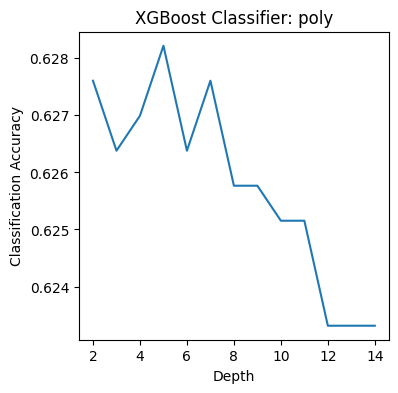

In [29]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['age', 'sex', 'weight'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'age:weight:sex'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')

# Height, Weight, Age, Sex

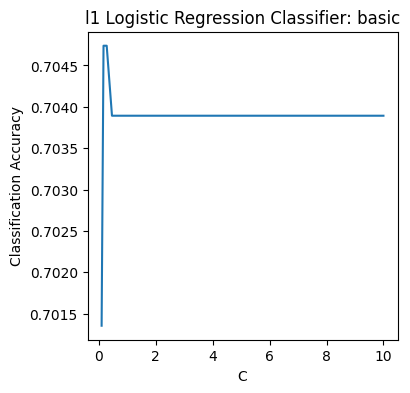

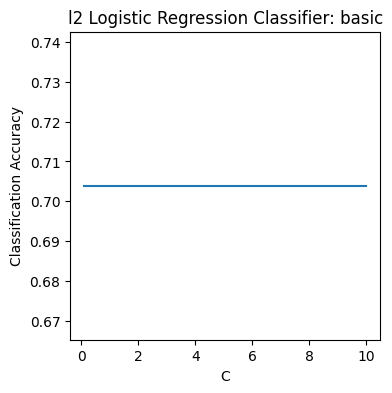

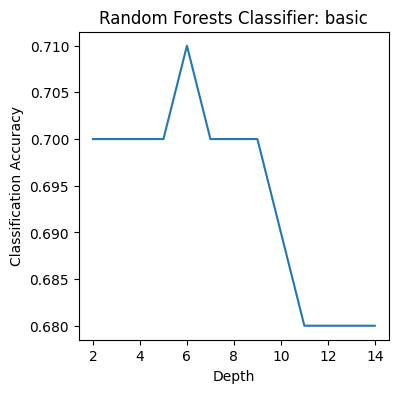

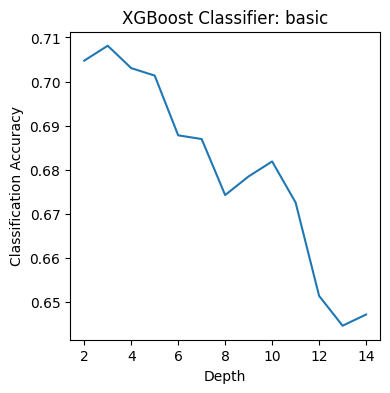

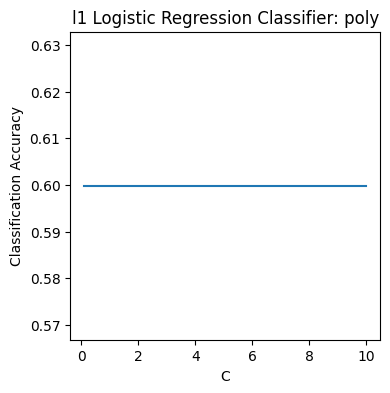

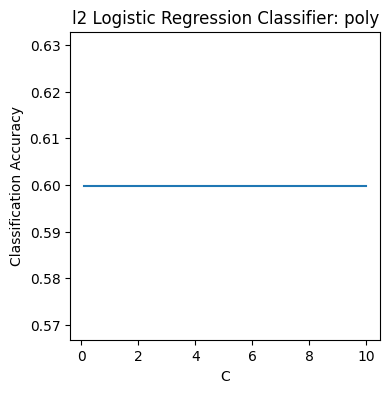

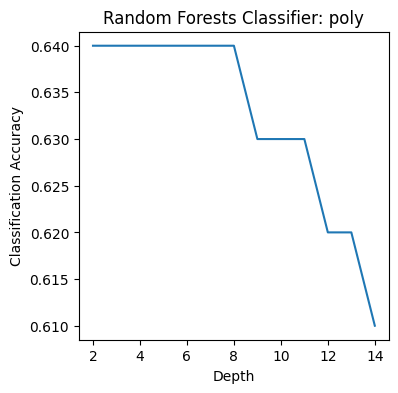

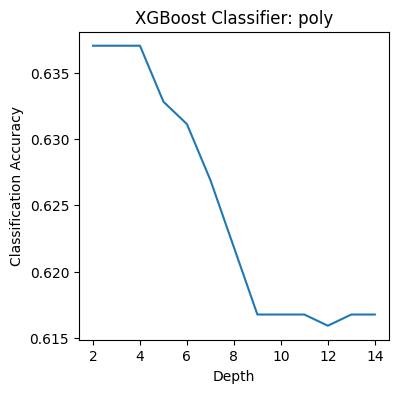

In [30]:
# Basic Features
train_data, train_labels, test_data, test_labels = load_data(['age', 'sex', 'weight', 'height'])

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'basic')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'basic')
random_forests(train_data, train_labels, test_data, test_labels, 'basic')
xg_boost(train_data, train_labels, test_data, test_labels, 'basic')

# Interaction Features
formula = 'age:weight:sex:height'
train_data = patsy.dmatrix(formula, data=train_data, return_type='dataframe')
test_data = patsy.dmatrix(formula, data=test_data, return_type='dataframe')

logistic_regression(train_data, train_labels, test_data, test_labels, 'l1', 'poly')
logistic_regression(train_data, train_labels, test_data, test_labels, 'l2', 'poly')
random_forests(train_data, train_labels, test_data, test_labels, 'poly')
xg_boost(train_data, train_labels, test_data, test_labels, 'poly')